  # CLASSIFICAÇÃO DE ESTRELAS COM DADOS DO GAIA.

# Introdução

Este notebook tem como finalidade a classificação de estrelas usando dados do telescópio espacial GAIA, utilizando técnicas de aprendizado não supervisionado. Os dados principais foram obtidos do próprio banco de dados SQL do telescópio (https://gea.esac.esa.int/archive/), enquanto os adicionais, de distância, foram buscados também em linguagem SQL, mas dessa vez usando python.
  
O projeto consiste em:

-> 1-Importação e Instalação das bibliotecas;

-> 2-Aquisição dos Dados;

-> 3-Tratamento dos Dados;

-> 4-Análise Exploratória;

-> 5-Preparação dos Modelos;

-> 6-Aplicação dos Modelos;

-> 7-Ajuste dos modelos;

-> 8-Resultados;

-> 9-Conclusão. 

------------------------------------------------------------------------------------------------------------------------------

# 1 - IMPORTANDO E INSTALANDO AS BIBLIOTECAS.

## 1.1 - Instalação de Novas Bibliotecas.

In [6]:
# Instalando o pacote yellowbrick para visualização de hiperparâmetros.

pip install yellowbrick

  Using cached yellowbrick-1.3.post1-py3-none-any.whl (271 kB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
## Instalando astroquery para a busca de dados em base de dados astronômicas.

pip install --pre astroquery

In [208]:
pip install rfpimp

  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10667 sha256=63fcc52255aad5d6655c93d485c1d6cfa9c3d8c8598358e5d55bc1d610157bc5
  Stored in directory: c:\users\diego\appdata\local\pip\cache\wheels\d9\f2\53\6d8c73011f73fc347598d683ff8b2343605ad43474ae083816
Successfully built rfpimp
Note: you may need to restart the kernel to use updated packages.


## 1.2 - Importando as Bibliotecas.

In [327]:
# Principais bibliotecas.
import pandas as pd
import numpy as np

#Bibliotecas de Visualização.
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gridspec
from yellowbrick.cluster import silhouette_visualizer, KElbowVisualizer
from pandas.plotting import radviz
import rfpimp

#Bibliotecas de busca.
from astroquery.gaia import Gaia

#Bibliotecas de Machine Learning.
from scipy.stats import normaltest
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, OPTICS, cluster_optics_dbscan
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

-----------------------------------------------------------------------------------------------------------------------------

# 2 - AQUISIÇÃO DOS DADOS.

## 2.1 - Telescópio GAIA.

A aquisição dos dados principais do GAIA foi feita através de uma busca no banco de dados SQL do próprio telescópio espacial (https://gea.esac.esa.int/archive/), buscando os melhores resultados limitando a uma parallax de 5x10^(-3) segundos de arco, que equilave a uma distância máxima de 652 anos luz. 

                                                              👇
<img src='busca_sql.png'>


*Tentar aprimorar a busca nas outras tabelas usando os ids da primeira busca!

## 2.2 - Dados complementares (Distância).

A base de dados do GAIA contém dados de diversos telescópios que podem ser acessados via astroquery (módulo do pacote astropy) e, coletados através de uma busca em SQL.  

In [2]:
# Mostrando as tabelas existentes na base de dados do GAIA.

tables = Gaia.load_tables(only_names=True)
for table in tables:
    print(table.name)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
external.apassdr9
external.gaiadr2_geometric_distance
external.gaiaedr3_distance
external.gaiaedr3_gcns_main_1
external.gaiaedr3_gcns_rejected_1
external.galex_ais
external.ravedr5_com
external.ravedr5_dr5
external.ravedr5_gra
external.ravedr5_on
external.sdssdr13_photoprimary
external.skymapperdr1_master
external.skymapperdr2_master
external.tmass_xsc
gaiadr1.aux_qso_icrf2_match
gaiadr1.ext_phot_zero_point
gaiadr1.allwise_best_neighbour
gaiadr1.allwise_neighbourhood
gaiadr1.gsc23_best_neighbour
gaiadr1.gsc23_neighbourhood
gaiadr1.ppmxl_best_neighbour
gaiadr1.ppmxl_neighbourhood
gaiadr1.sdss_dr9_best_neighbour
gaiadr1.sdss_dr9_neighbourhood
gaiadr1.tmass_best_neighbour
gaiadr1.tmass_neighbourhood
gaiadr1.ucac4_best_neighbour
gaiadr1.ucac4_neighbourhood
gaiadr1.urat1_best_neighbour
gaiadr1.urat1_neighbourhood
gaiadr1.cepheid
gaiadr1.phot_vari

Estamos interessados nas informações sobre as distâncias das estrelas que são encontradas na tabela 'external.gaiaedr3_distance'.

In [3]:
# Acessando a tabela com as informações sobre a distância.

table_metadata = Gaia.load_table('external.gaiaedr3_distance')
print(table_metadata)

Retrieving table 'external.gaiaedr3_distance'
TAP Table name: external.external.gaiaedr3_distance
Description: 
Bailer-Jones et al. (2021) EDR3 distances. <p> Estimating distances from parallaxes. V: Geometric and photogeometric distances to 1.47 billion stars in Gaia Early Data Release 3.
Bailer-Jones et al. 2021 AJ 161 147. Data replicated from gedr3dist.main table at GAVO Data Center TAP service https://dc.g-vo.org/tap and TAP metadata as of December 2020.
<p>
    Original table description.
<p>
    We estimate the distance from the Sun to sources in Gaia EDR3 that have
    parallaxes. We provide two types of distance estimate, together with
    their corresponding asymmetric uncertainties, using Bayesian posterior
    density functions that we sample for each source. Our prior is based
    on a detailed model of the 3D spatial, colour, and magnitude
    distribution of stars in our Galaxy that includes a 3D map of
    interstellar extinction.
<p>
    The first type of distance esti

In [4]:
# Verificando as colunas nas tabela 'external.gaiaedr3_distance'.

for column in table_metadata.columns:
    print(column.name)

source_id
r_med_geo
r_lo_geo
r_hi_geo
r_med_photogeo
r_lo_photogeo
r_hi_photogeo
flag


Vemos que a tabela possui várias colunas, mas estamos interessados apenas na distância geométrica (r_med_geo), que será buscado através da query seguinte, junto com o ID para fundirmos com a outra base de dados.

In [5]:
query = """SELECT TOP 10000
source_id, r_med_geo 
FROM external.gaiaedr3_distance
WHERE (external.gaiaedr3_distance.r_med_geo<200)"""


In [457]:
# Busca dos dados.

job = Gaia.launch_job(query)
job

In [7]:
print(job)

<Table length=10000>
   name    dtype  unit                                           description                                          
--------- ------- ---- -----------------------------------------------------------------------------------------------
source_id   int64      Unique source identifier. Note that this *cannot* be matched against the DR1 or DR2 source_ids.
r_med_geo float32   pc                The median of the geometric distance posterior. The geometric distance estimate.
Jobid: None
Phase: COMPLETED
Owner: None
Output file: 1642536699455O-result.vot.gz
Results: None


In [458]:
# Verificando se o resultado está em uma tabela astropy.

results = job.get_results()
type(results)

astropy.table.table.Table

In [459]:
# Visualizando os resultados.

results

source_id,r_med_geo
,pc
int64,float32
5853498713190525696,1.3019114
4472832130942575872,1.8281064
3864972938605115520,2.4083583
762815470562110464,2.5459516
2947050466531873024,2.670147
5140693571158946048,2.67459
5140693571158739840,2.718584
4075141768785646848,2.9754312


## 2.3 - Construindo o Dataset.

Nessa seção vamos fundir as duas tabelas de dados criando um dataset completo.

In [460]:
#Carregando os dados do GAIA em um dataframe.

GAIA = pd.read_csv('star_classification.csv')
GAIA.head(3)

,designation,ref_epoch,ra,dec,parallax,pm,astrometric_excess_noise,nu_eff_used_in_astrometry,pseudocolour,visibility_periods_used,...,phot_rp_mean_mag,phot_proc_mode,bp_rp,bp_g,g_rp,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b
0,Gaia EDR3 4141159642346435712,2016.0,258.506108,-13.719064,7.000003,7.172875,2.301260,NaN,2.139485,9,...,20.014688,1.0,1.517588,0.646324,0.871263,NaN,NaN,NaN,8.948281,14.382036
1,Gaia EDR3 3781327832039804160,2016.0,157.523249,-2.591879,7.000003,36.325535,0.000000,1.257106,NaN,14,...,15.539074,0.0,2.770182,1.566406,1.203775,NaN,NaN,NaN,248.413311,44.802440
2,Gaia EDR3 468048463423213184,2016.0,45.346241,65.073320,7.000004,194.900070,1.641339,NaN,1.187890,23,...,18.714716,0.0,2.695568,1.171503,1.524065,NaN,NaN,NaN,136.078447,5.572854


In [461]:
# Transformando as tabelas astropy das informações de distância em dataframe.

stars_distance = pd.DataFrame()
stars_distance['id'] = results['source_id']
stars_distance['distance(pc)'] = results['r_med_geo']
stars_distance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            10000 non-null  int64  
 1   distance(pc)  10000 non-null  float32
dtypes: float32(1), int64(1)
memory usage: 117.3 KB


Os ids estão em int64, e para que seja possível fundir com o DataFrame GAIA precisamos trandformá-los em str.

In [462]:
# Renomeando a coluna designation do GAIA.

GAIA = GAIA.rename(columns={'designation': 'id'})

# Removendo as os caracteres 'Gaia EDR3 ' do ID para fundir com outros dataframes.

GAIA.replace({'Gaia EDR3 ': ''}, regex=True, inplace=True)

# Transformando os ids em strings

stars_distance['id'] = stars_distance['id'].astype(str)
GAIA['id'] = GAIA['id'].astype(str)

# Fundindo os dois DataFrames

stars_data = pd.merge(stars_distance, GAIA, how = 'inner', on = 'id')

In [463]:
# Criando uma cópia dos dados para termos um backup.

stars_data_copy = stars_data

# 03 - TRATAMENTO DOS DADOS.

No tratamento de dados vamos estudar se há dados faltantes, imputando valores se for viável, eliminar dados ruins passando alguns filtros, organizar nossa base de dados eliminando atributos desnecessários, e criar novos atributos úteis.

In [18]:
# Verificando se existe dados duplicados.

stars_data.duplicated(subset = ['id']).sum()

0

## 3.1 - Dados Faltantes.

In [14]:
#Coletando informações sobre a base de dados

stars_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            10000 non-null  object 
 1   distance(pc)                  10000 non-null  float32
 2   ref_epoch                     10000 non-null  float64
 3   ra                            10000 non-null  float64
 4   dec                           10000 non-null  float64
 5   parallax                      10000 non-null  float64
 6   pm                            10000 non-null  float64
 7   astrometric_excess_noise      10000 non-null  float64
 8   nu_eff_used_in_astrometry     7754 non-null   float64
 9   pseudocolour                  2246 non-null   float64
 10  visibility_periods_used       10000 non-null  int64  
 11  phot_g_mean_flux_over_error   9986 non-null   float64
 12  phot_g_mean_mag               9986 non-null   float64
 13  ph

Na célula acima vemos que não há nenhum dado categórico, e que existe dados faltantes em algumas colunas. Se somarmos os dados faltantes dos atributos 'nu_eff_used_in_astrometry' e 'pseudocolor', chegamos ao valor total de linhas do dataset, o que sugere que o dado faltante em um pode ser completado com o outro, já que significam a mesma coisa. Estudaremos melhor o caso adiante.

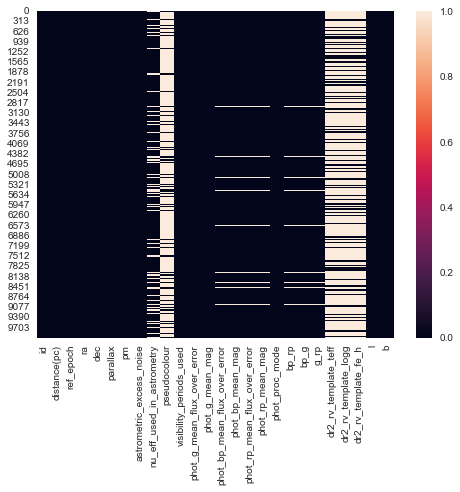

In [15]:
# Mapeando os dados nulos e NAN.

plt.figure(figsize=(8,6))
sns.heatmap(stars_data.isnull())
plt.show()

Nesse mapeamento podemos notar que: 

-> template_teff, template_logg, e template_fe_h, possuem muitos dados faltantes, logo eliminaremos essas colunas. 

-> Os dados nulos da coluna 'nu_eff_used_in_astrometry' serão completados pelos valores de 'pseudocolor', que é o valor estimado.

-> Os dados faltantes dos 'flux_over_error' serão deletados, assim como as medidas de fluxo das respectivas bandas, e os outros dados que dependem deles, como por exemplo: 'bc_rp'. Eles não farão falta, pois, temos uma grande quantidade de dados.



In [464]:
# Preenchendo os linhas faltantes de 'nu_eff_used_in_astrometry'.

stars_data['nu_eff_used_in_astrometry'].fillna(axis=0, value=stars_data['pseudocolour'],inplace=True)

## 3.2 - Filtragem dos Dados.

A qualidade da calibração dos dados é indicada pelo valor do atributo 'phot_proc_mode', quanto menor o valor, melhor a calibração.

In [16]:
# Conferindo a data e a qualidade dos dados.

print(stars_data['ref_epoch'].value_counts())
print(stars_data['phot_proc_mode'].value_counts())

2016.0    10000
Name: ref_epoch, dtype: int64
0.0    9524
2.0     245
1.0     227
Name: phot_proc_mode, dtype: int64



Os dados tem uma boa calibraçao em quase sua totalidade, mas além do da qualidade da calibração usaremos também os erros na filtragem seguindo os seguintes critérios:

-> phot_proc_mode < 2

-> visibility_periods_used > 8

-> astrometric_excess_noise < 1

-> phot_g_mean_flux_over_error > 50

-> phot_bp_mean_flux_over_error > 20

-> phot_rp_mean_flux_over_error > 20

In [465]:
#Filtrando os dados.

data_filter = stars_data['phot_proc_mode']<2
stars_data = stars_data[data_filter]
data_filter2 = stars_data['visibility_periods_used']>8
stars_data = stars_data[data_filter2]
data_filter3 = stars_data['astrometric_excess_noise']<1
stars_data = stars_data[data_filter3]
data_filter4 = stars_data['phot_g_mean_flux_over_error']>50
stars_data = stars_data[data_filter4]
data_filter5 = stars_data['phot_bp_mean_flux_over_error']>20
stars_data = stars_data[data_filter5]
data_filter6 = stars_data['phot_rp_mean_flux_over_error']>20
stars_data = stars_data[data_filter6]


A próxima célula serve apenas para reorganizar os índices, já que algumas linhas foram excluídas.

In [466]:
stars_data.to_csv('stars.csv')
stars_data = pd.read_csv('stars.csv')

## 3.3 - Criando Novos Atributos.

As medidas de magnitude(brilho) em sí não faz muito sentido, pois, uma estrela extremamente brilhante que esteja muito longe terá sua medida subestimada em relação a uma estrela pouco brilhante que esteja bem próxima. Logo, precisamos padronizar a medida para que ela reflita as propriedades físicas da estrela, para isso usaremos o módulo de distância que calcula o brilho que a estrela teria a uma distância de 10 parsecs, resolvendo assim nosso problema.

In [467]:
# Aplicando o módulo de distância para padronizar as medidads de magnitude.

stars_data['absmag(g)'] = stars_data['phot_g_mean_mag']+5-(5*np.log10(stars_data['distance(pc)']))
stars_data['absmag(r)'] = stars_data['phot_rp_mean_mag']+5-(5*np.log10(stars_data['distance(pc)']))
stars_data['absmag(b)'] = stars_data['phot_bp_mean_mag']+5-(5*np.log10(stars_data['distance(pc)']))

Assim como a medida de magnitude bruta, as medidas de declinação(dec) e ascenção reta(ra) também não possuem muito significado por sí só, mas combinando com a distância podemos calcular a posição das estrelas em coordenadas esféricas tomando a terra como centro, tornando essa medida mais útil se cada tipo de estrela possuir uma localização preferencial.

In [468]:
# Transformando o valor de dec que vai de 90 a -90 graus para o ângulo polar das coordenadas esféricas de 0 a 180 graus.

stars_data['theta'] = stars_data['dec']
for r in range(len(stars_data)):
    if stars_data['dec'][r] < 0:
        stars_data['theta'][r] = np.abs(stars_data['dec'][r]) + 90
    else:
        stars_data['theta'][r] = 90 - stars_data['dec'][r]

# Transformando os ângulos de graus para radianos.

stars_data['theta_rad'] = (stars_data['theta']*np.pi)/180
stars_data['phi_rad'] = (stars_data['ra']*np.pi)/180

# Transfromando de coordenadas esféricas para retângulares (x,y,z).

stars_data['x'] = stars_data['distance(pc)']*np.cos(stars_data['phi_rad'])*np.sin(stars_data['theta_rad']);
stars_data['y'] = stars_data['distance(pc)']*np.sin(stars_data['phi_rad'])*np.sin(stars_data['theta_rad']);
stars_data['z'] = stars_data['distance(pc)']*np.cos(stars_data['theta_rad']);


C:\Users\Diego\AppData\Local\Temp/ipykernel_16480/887884889.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stars_data['theta'][r] = np.abs(stars_data['dec'][r]) + 90
C:\Users\Diego\AppData\Local\Temp/ipykernel_16480/887884889.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stars_data['theta'][r] = 90 - stars_data['dec'][r]


In [469]:
# Verificando alguns valores manualmente para garantir.

stars_data[['dec', 'theta', 'theta_rad','ra', 'phi_rad','x', 'y', 'z','absmag(g)','absmag(r)','absmag(b)']].head(15) 

,dec,theta,theta_rad,ra,phi_rad,x,y,z,absmag(g),absmag(r),absmag(b)
0,-62.676075,152.676075,2.664700,217.392321,3.794212,-0.474794,-0.362907,-1.156651,13.411842,11.995628,15.800209
1,4.739420,85.260580,1.488078,269.448503,4.702764,-0.017536,-1.821771,0.151046,11.883967,10.648084,13.481781
2,7.002727,82.997273,1.448576,164.103190,2.864141,-2.298976,0.654742,0.293619,14.129786,12.676845,16.861682
3,35.948653,54.051347,0.943374,165.830960,2.894296,-1.998356,0.504513,1.494626,9.521921,8.446262,10.661871
4,-23.837097,113.837097,1.986832,282.458789,4.929836,0.587155,-2.657531,-1.202484,11.758664,10.530397,13.364433
5,44.170376,45.829624,0.799878,355.480015,6.204297,2.258963,-0.178577,2.201320,12.881384,11.519121,15.048535
6,-35.847164,125.847164,2.196447,346.503917,6.047634,2.591380,-0.621948,-1.925375,8.937555,7.907028,10.005314
7,0.799120,89.200880,1.556849,176.937688,3.088145,-3.369075,0.180240,0.047060,11.960132,10.686899,13.720158
8,38.756073,51.243927,0.894375,316.753663,5.528394,1.985875,-1.867885,2.188560,7.732746,6.839013,8.554354
9,38.763862,51.236138,0.894239,316.748479,5.528304,1.985590,-1.867956,2.189042,7.048703,6.259193,7.721783


## 3.4 - Organizando a base de dados.

Com os dados devidamente tratados, é hora de eliminar os atributos cujo a única utilidade era a filtragem, os que possuem muitos dados faltantes, e  os que foram criados apenas para calcular atributos mais úteis.

In [470]:
# Eliminando as colunas desnecessárias.

stars_data = stars_data.drop(columns=['ref_epoch','dr2_rv_template_teff','phot_proc_mode','dr2_rv_template_logg',
                                      'dr2_rv_template_fe_h','dr2_rv_template_teff','pseudocolour','phot_g_mean_flux_over_error',
                                      'phot_bp_mean_flux_over_error','phot_rp_mean_flux_over_error','astrometric_excess_noise',
                                      'visibility_periods_used','phi_rad','theta_rad','theta','id','phot_g_mean_mag',
                                      'phot_rp_mean_mag','phot_bp_mean_mag'])

# Eliminando as linhas com dados faltantes.

stars_data.dropna(axis=0, how='any', inplace=True)


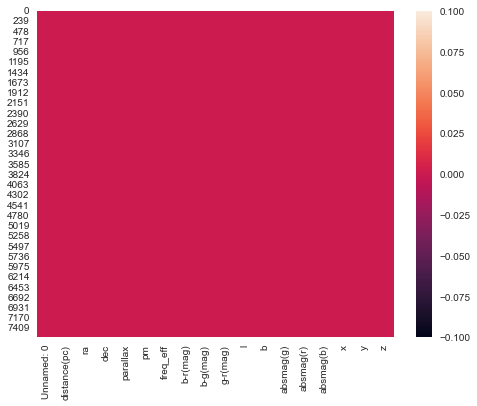

In [471]:
# Renomeando as colunas para ficar mais intuitivo .

stars_data = stars_data.rename(columns={'nu_eff_used_in_astrometry': 'freq_eff','bp_rp': 'b-r(mag)',
                                        'bp_g': 'b-g(mag)','g_rp': 'g-r(mag)'})

# Verificando se o dataframe está completo.

plt.figure(figsize=(8,6))
sns.heatmap(stars_data.isnull())
plt.show()

**Agora não temos nenhum dado faltante!**

# 04 - Análise exploratória.

## 4.1 - Diagrama HR.

Para garantir que a filtragem dos dados funcionou vamos montar um diagrama HR com os nossos dados.

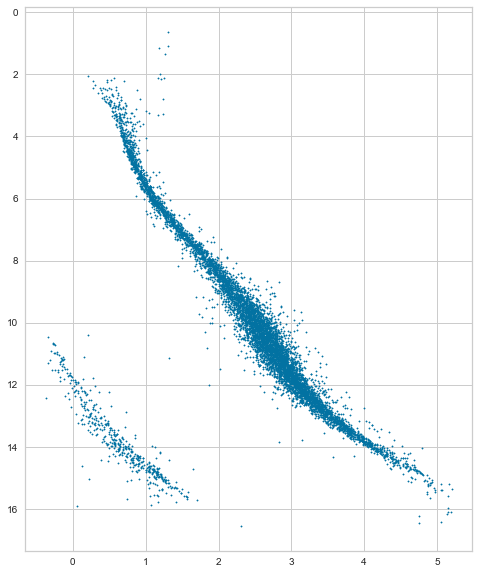

In [504]:
# Plotagem do diagrama HR.

f, ax = plt.subplots(figsize=(8,10))
plt.scatter(x=stars_data['b-r(mag)'], y=stars_data['absmag(g)'], s=2)
'''

sns.scatterplot(x='bp_rp',y='phot_g_mean_mag',data=stars_data,palette='dark')'''
ax.invert_yaxis()

Filtragem ok!

## 4.1 - Estatística descritiva.

In [71]:
# Estatística descritiva.

describe = stars_data.describe().T
describe['kurtose'] = stars_data.kurtosis()
describe['viés']= stars_data.skew()
describe.round(2)

,count,mean,std,min,25%,50%,75%,max,kurtose,viés
Unnamed: 0,7616.0,4873.69,2885.78,0.00,2339.50,4820.50,7349.25,9999.00,-1.20,0.05
distance(pc),7616.0,22.95,5.91,1.30,19.27,24.17,27.73,30.65,0.14,-0.86
ra,7616.0,181.54,103.71,0.15,91.16,182.46,272.08,359.97,-1.20,-0.02
dec,7616.0,-0.17,39.44,-87.76,-31.10,0.00,29.90,89.44,-0.83,0.02
parallax,7616.0,48.97,26.81,32.57,36.03,41.34,51.85,768.07,111.37,7.34
pm,7616.0,399.64,433.68,0.43,175.89,297.14,490.86,10393.35,92.96,6.86
freq_eff,7616.0,1.32,0.13,0.98,1.24,1.28,1.38,1.88,1.07,1.24
b-r(mag),7616.0,2.39,0.98,-0.37,1.77,2.57,3.01,5.20,-0.22,-0.32
b-g(mag),7616.0,1.33,0.68,-1.07,0.84,1.39,1.73,3.64,-0.10,0.14
g-r(mag),7616.0,1.06,0.33,-0.24,0.92,1.17,1.27,2.96,1.17,-1.01


Os resultados que mais chamam a atenção por enquanto é o viés e a kurtose muito maior na parallax em comparação com os outros.

## 4.2 - Histogramas.

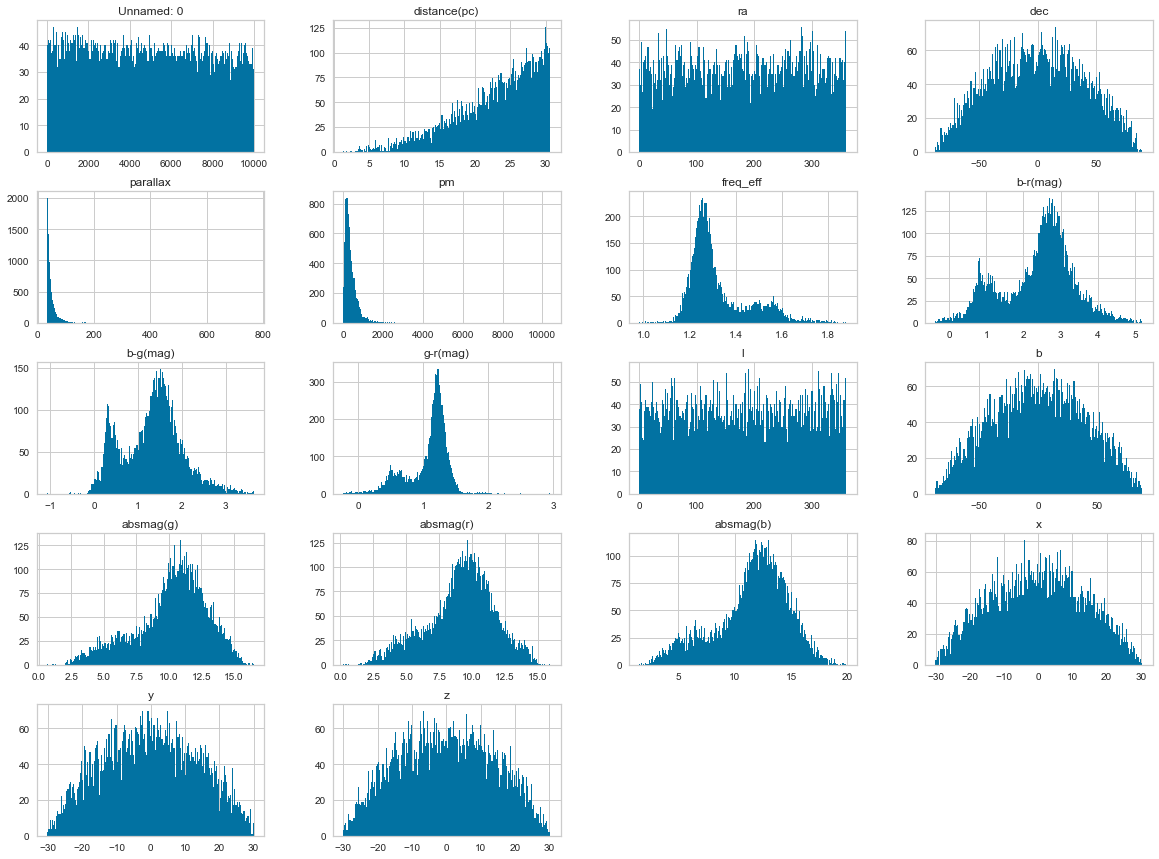

In [49]:
%matplotlib inline
stars_data.hist(figsize=(20,15), bins=200)
plt.show()

Pelos histogramas percebe-se que os atributos l, ra, e unamed são quase constantes, não trazendo quase nenhuma informação para o modelo.

## 4.3 -  Correlação.

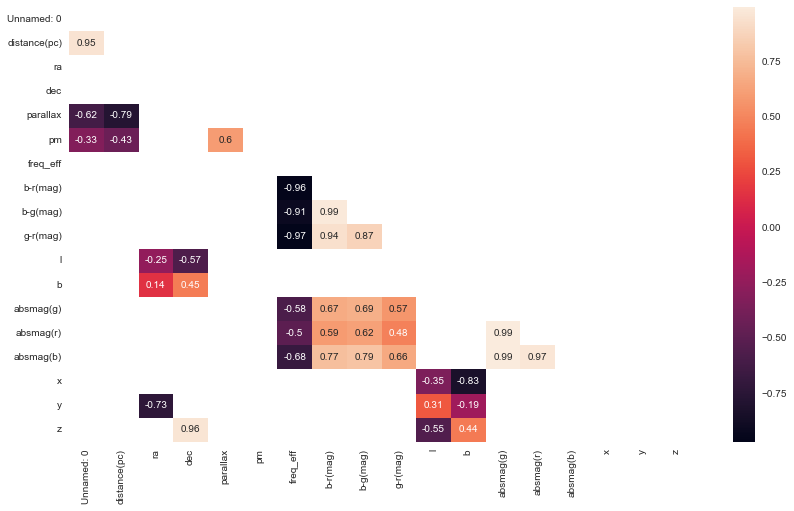

In [50]:
%matplotlib inline
plt.figure(figsize=(14, 8))
corr=stars_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool));
sns.heatmap(corr[(corr > .1) | (corr < -.1)], annot = True, mask = mask);
#sns.heatmap(full_dataset.corr(),vmin = -1, vmax = +1, annot = True)
plt.show()

No gráfico acima algumas temos algumas correlações importantes, são elas:

-> Alta correlação negativa entre freq_eff e a deferenças de magnitude;

-> Alta correlação entre os valores de magnitude absoluta;

-> Esperada alta correlação entre parallax e distância, já que o segundo atributo é calculado através do primeiro;

-> Alta correlação dec-z e ra-y, mesmo caso acima.

Provavelmente só será necessário manter apenas um atributo de cada tópico acima.

## 4.4 - Boxplots.

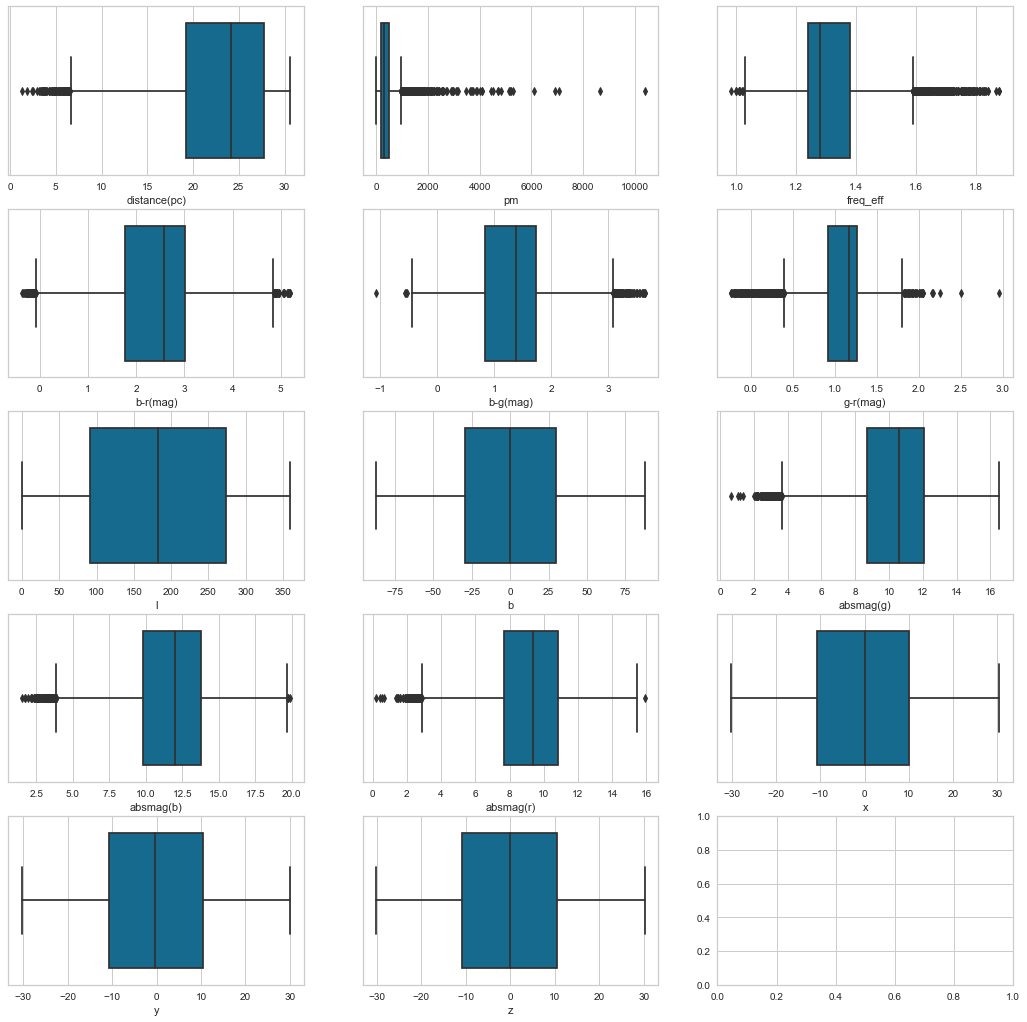

In [73]:
fig, axis = plt.subplots(5,3, figsize = (18,18))

sns.boxplot(data = stars_data, x = 'distance(pc)', ax = axis[0,0]);
sns.boxplot(data = stars_data, x = 'pm', ax = axis[0,1]);
sns.boxplot(data = stars_data, x = 'freq_eff', ax = axis[0,2]);

sns.boxplot(data = stars_data, x = 'b-r(mag)', ax = axis[1,0]);
sns.boxplot(data = stars_data, x = 'b-g(mag)', ax = axis[1,1]);
sns.boxplot(data = stars_data, x = 'g-r(mag)', ax = axis[1,2]);


sns.boxplot(data = stars_data, x = 'l', ax = axis[2,0]);
sns.boxplot(data = stars_data, x = 'b', ax = axis[2,1]);
sns.boxplot(data = stars_data, x = 'absmag(g)', ax = axis[2,2]);

sns.boxplot(data = stars_data, x = 'absmag(b)', ax = axis[3,0]);
sns.boxplot(data = stars_data, x = 'absmag(r)', ax = axis[3,1]);
sns.boxplot(data = stars_data, x = 'x', ax = axis[3,2]);

sns.boxplot(data = stars_data, x = 'y', ax = axis[4,0]);
sns.boxplot(data = stars_data, x = 'z', ax = axis[4,1]);





Alguns atributos possuem bastante outliers, o que vai influir na padronização.

------------------------------------------------------------------------------------------------------------------------------

# 05 - Preparação dos dados para o modelo.

## 5.1 - Criação dos Dataframes para o modelo.

In [475]:
# Criando um Dataframe para guardar as coordenadas.

coo = pd.DataFrame()

coo['x'] = stars_data['x']
coo['y'] = stars_data['y']
coo['z'] = stars_data['z']
coo['b'] = stars_data['b']
coo['l'] = stars_data['l']
coo['distance(pc)'] = stars_data['distance(pc)']

In [476]:
# Criando um Dataframe para o modelo.

df_model_full = stars_data
df_model_full = df_model_full.drop(columns=['ra','dec','Unnamed: 0','l'])

Para a seleção dos melhores atributos vamos usar a biblioteca rfpimp que faz o treinamento de uma floresta aleatória para cada atributo tentando prever o outro, para assim verificar se ahá dados colineares.

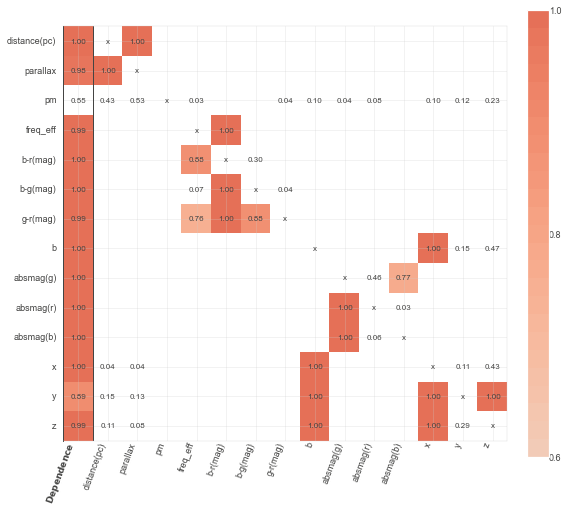

In [477]:
rfpimp.plot_dependence_heatmap(rfpimp.feature_dependence_matrix(df_model_full),figsize=(8,8))
fig = plt.gcf()

O resultado do rfpimp nos mostra que com a 'parallax' é possível prever a distância, o atributo b-r(mag) prevê g-r, b-g, e freq_eff, e com absmag(g) é possível prever os outros valores de absmag, assim como esperado pela pontuação da correlação. Outra informação é que o atributo b deduz as coordenadas, mas decidi mantê-las mesmo assim, pois, elas trazem consigo as informações espaciais de forma mais completa.

Logo, criarei um Dataframe tirando os atributos correlacionados e outro completo com a finalidade de ter certeza do melhor dataset.

In [478]:
df_model = stars_data
df_model = df_model.drop(columns=['ra', 'dec', 'Unnamed: 0', 'l','parallax', 'b-g(mag)', 'g-r(mag)', 'freq_eff',
                                'absmag(r)', 'absmag(b)','x','y','z','distance(pc)','pm'])

## 5.2 - Padronização.

In [234]:
# Verificando 
for col in df_model:
    stat, p = normaltest(df_model[col])
    print('stat: %.3f, p: %.3f' %(stat, p))
    if p > 0.05:
        print('{}: Probably Gaussian\n'.format(col))
    else:
        print('{}: Probably Not Gaussian\n'.format(col))

stat: 719.449, p: 0.000
distance(pc): Probably Not Gaussian

stat: 9724.733, p: 0.000
pm: Probably Not Gaussian

stat: 28.712, p: 0.000
b-g(mag): Probably Not Gaussian

stat: 1098.571, p: 0.000
g-r(mag): Probably Not Gaussian

stat: 622.091, p: 0.000
b: Probably Not Gaussian

stat: 422.886, p: 0.000
absmag(g): Probably Not Gaussian

stat: 708.125, p: 0.000
x: Probably Not Gaussian

stat: 795.696, p: 0.000
y: Probably Not Gaussian

stat: 965.477, p: 0.000
z: Probably Not Gaussian



In [235]:
mms = MinMaxScaler()
rs = RobustScaler()

In [479]:
# MinMaxScaler 
df_model['b'] = mms.fit_transform(df_model[['b']].values)
#df_model['x'] = mms.fit_transform(df_model[['x']].values)
#df_model['y'] = mms.fit_transform(df_model[['y']].values)
#df_model['z'] = mms.fit_transform(df_model[['z']].values)


# RobustScaler
#df_model['distance(pc)'] = rs.fit_transform(df_model[['distance(pc)']].values)
#df_model['pm'] = rs.fit_transform(df_model[['pm']].values)
#df_model['freq_eff'] = rs.fit_transform(df_model[['freq_eff']].values)
df_model['b-r(mag)'] = rs.fit_transform(df_model[['b-r(mag)']].values)
#df_model['b-g(mag)'] = rs.fit_transform(df_model[['b-g(mag)']].values)
#df_model['g-r(mag)'] = rs.fit_transform(df_model[['g-r(mag)']].values)
df_model['absmag(g)'] = rs.fit_transform(df_model[['absmag(g)']].values)
#df_model['absmag(r)'] = rs.fit_transform(df_model[['absmag(r)']].values)
#df_model['absmag(b)'] = rs.fit_transform(df_model[['absmag(b)']].values)
#df_model['parallax'] = rs.fit_transform(df_model[['parallax']].values)


In [396]:
df_model = df_model-df_model.mean()
df_model = df_model/df_model.std()

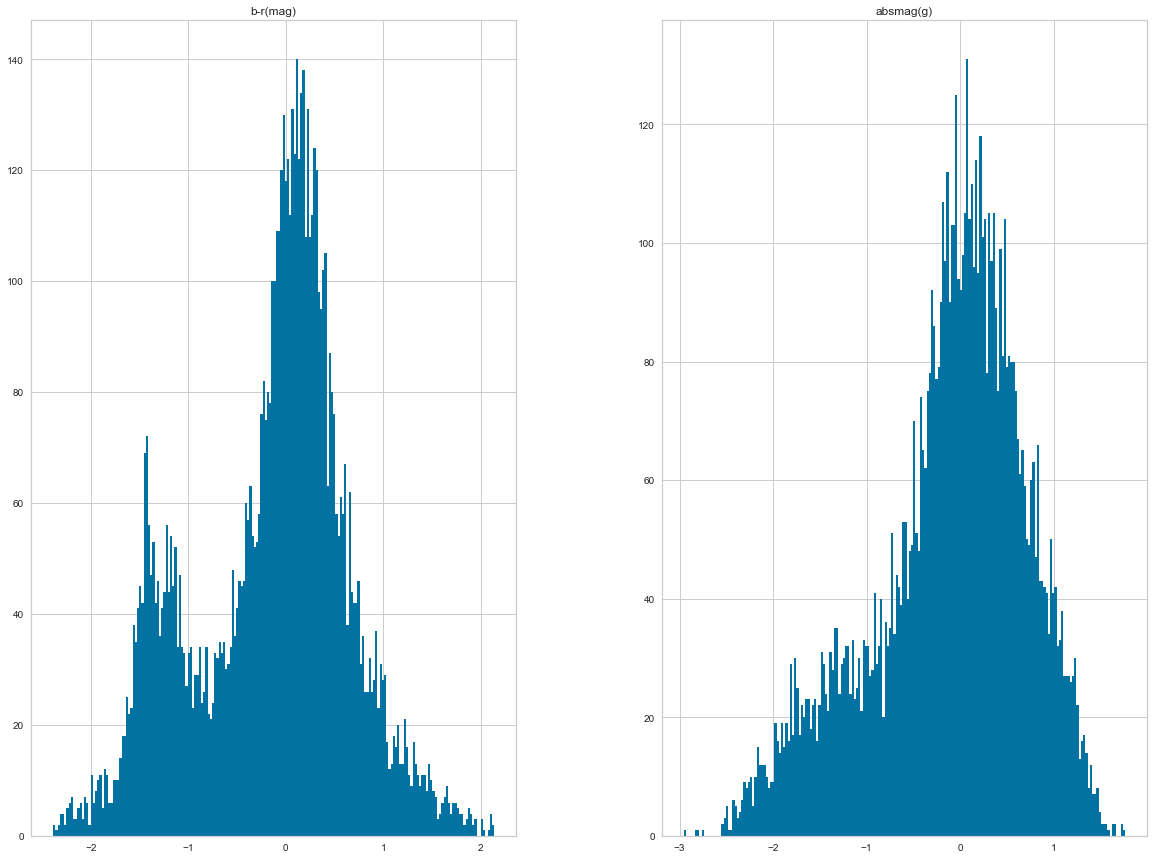

In [405]:
%matplotlib inline
df_model.hist(figsize=(20,15), bins=200)
plt.show()

In [248]:
df_model.std()

distance(pc)   -5.192217e-16
pm             -7.503772e-18
b-g(mag)        3.285770e-16
g-r(mag)        1.184546e-15
b               3.034673e-15
absmag(g)      -3.023936e-15
x               1.938080e-15
y              -1.734374e-15
z               2.238974e-15
dtype: float64

In [249]:
df_model.mean()

distance(pc)   -5.192217e-16
pm             -7.503772e-18
b-g(mag)        3.285770e-16
g-r(mag)        1.184546e-15
b               3.034673e-15
absmag(g)      -3.023936e-15
x               1.938080e-15
y              -1.734374e-15
z               2.238974e-15
dtype: float64

## 4.3 -  Determinação da quantidade de clusters.

In [480]:
train_set, test_set = train_test_split(df_model, test_size=0.2, random_state=42)
print(len(train_set), 'train + ', len(test_set), 'test')

6092 train +  1524 test


### 4.3.1 - Teste das métricas.

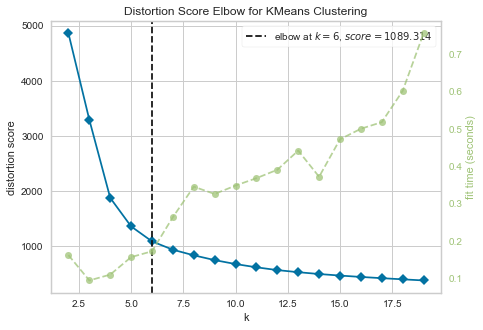

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [481]:
plt.figure(figsize=(7,5))
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20))
visualizer.fit(df_model)
visualizer.show()

C:\Users\Diego\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([[<AxesSubplot:xlabel='k'>, <AxesSubplot:xlabel='k'>],
       [<AxesSubplot:xlabel='k'>, <AxesSubplot:xlabel='k'>]], dtype=object)

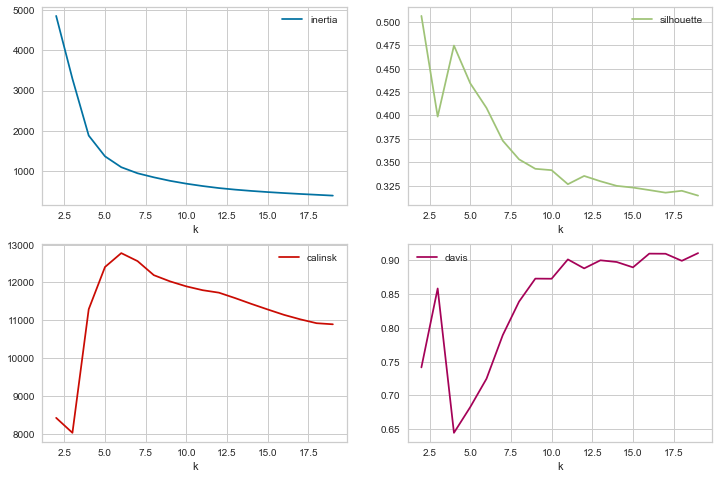

In [482]:
inertias = []
sils = []
chs = []
dbs = []
sizes =range(2,20)
for k in sizes:
    k2 = KMeans(random_state = 42, n_clusters = k)
    k2.fit(df_model)
    inertias.append(k2.inertia_)
    sils.append(metrics.silhouette_score(df_model, k2.labels_))
    chs.append(metrics.calinski_harabasz_score(df_model, k2.labels_))
    dbs.append(metrics.davies_bouldin_score(df_model, k2.labels_))
    
fig, ax = plt.subplots(figsize=(12, 8))

pd.DataFrame({'inertia': inertias, 'silhouette': sils, 'calinsk': chs, 'davis': dbs, 'k': sizes}).set_index('k').plot(ax=ax,subplots=True,layout=(2,2))

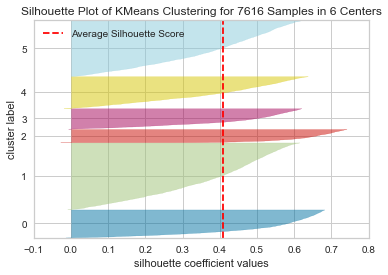

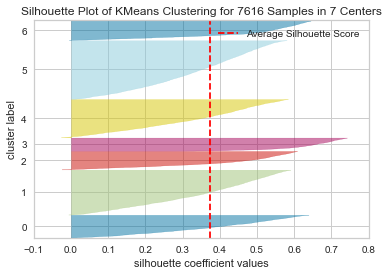

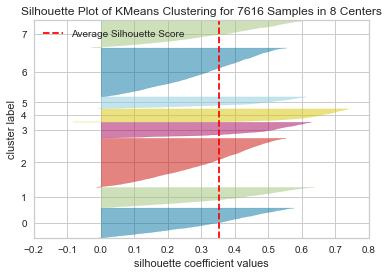

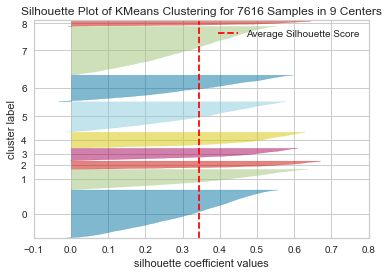

<Figure size 432x288 with 0 Axes>

In [483]:
#fig, axes = plt.subplots(2,2, figsize=(12,8))
#axes = axes.reshape(4)

silhouette_visualizer(KMeans(6, random_state=42), df_model, colors='yellowbrick')
silhouette_visualizer(KMeans(7, random_state=42), df_model, colors='yellowbrick')
silhouette_visualizer(KMeans(8, random_state=42), df_model, colors='yellowbrick')
silhouette_visualizer(KMeans(9, random_state=42), df_model, colors='yellowbrick')
plt.tight_layout()

### 4.3.2 - Teste para Algoritmos de Densidade.

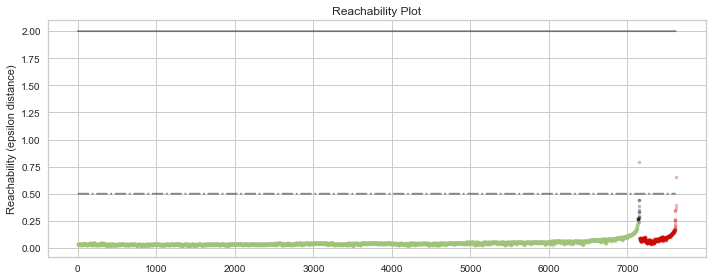

In [500]:

clust = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)

# Run the fit
clust.fit(df_model)


space = np.arange(len(df_model))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 4))
G = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(G[0, :])



# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")


plt.tight_layout()
plt.show()

### 4.3.2 - Teste Com Clustering Aglomerativo.

In [485]:
aux = df_model.copy()
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(aux)
clustering
labels = clustering.labels_
aux['label'] = labels

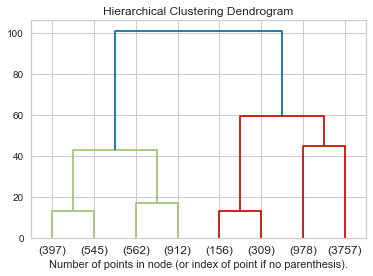

In [486]:

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode="level", p=2)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


### 4.3.4 - Teste por visualização.

# Usaremos também o modelo de mistura gaussiana com os mesmos parâmetros do kmeans

In [576]:
train_set, test_set = train_test_split(df_model, test_size=0.2, random_state=42)
print(len(train_set), 'train + ', len(test_set), 'test')

6092 train +  1524 test


In [670]:

kmeans6 = KMeans(n_clusters=6,n_init=10,random_state=42 ).fit(train_set)
k6 = kmeans6.predict(test_set)
kmeans7 = KMeans(n_clusters=7,n_init=10,random_state=42 ).fit(train_set)
k7 = kmeans7.predict(test_set)
kmeans8 = KMeans(n_clusters=8,n_init=10,random_state=42 ).fit(train_set)
k8 = kmeans8.predict(test_set)
kmeans9 = KMeans(n_clusters=9,n_init=10,random_state=42 ).fit(train_set)
k9 = kmeans9.predict(test_set)
kmeans10 = KMeans(n_clusters=10,n_init=10,random_state=42 ).fit(train_set)
k10 = kmeans10.predict(test_set)

kmeans5 = KMeans(n_clusters=5,n_init=10,random_state=42 ).fit(train_set)
k5 = kmeans5.predict(test_set)
kmeans4 = KMeans(n_clusters=4,n_init=10,random_state=42 ).fit(train_set)
k4 = kmeans4.predict(test_set)

In [650]:
kmeans3 = KMeans(n_clusters=4,n_init=10,random_state=42 ).fit(train_set)
k3 = kmeans3.predict(test_set)

In [579]:
treino, teste = train_test_split(stars_data, test_size=0.2, random_state=42)
print(len(treino), 'train + ', len(teste), 'test')

6092 train +  1524 test


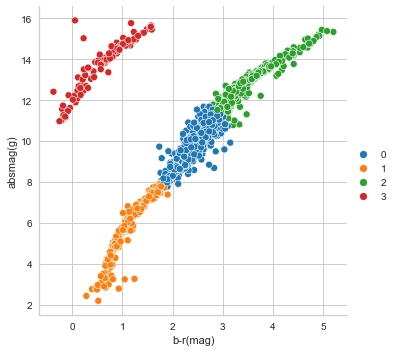

In [665]:
#fig, ax = plt.subplots(3,3,figsize=(12, 8))
#test_set['class']=kmeans6.predict(test_set)
sns.relplot(
    data=test_set,
    x=teste['b-r(mag)'], y=teste["absmag(g)"],
    hue=k4,palette='tab10'
)

C:\Users\Diego\AppData\Local\Temp/ipykernel_16480/3654529351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['labels'] = kmeans4.labels_
C:\Users\Diego\AppData\Local\Temp/ipykernel_16480/3654529351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['labels'] = k4
C:\Users\Diego\AppData\Local\Temp/ipykernel_16480/3654529351.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

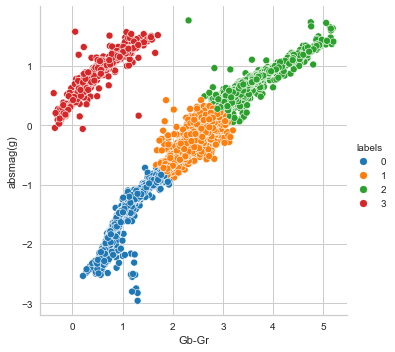

In [671]:
train_set['labels'] = kmeans4.labels_
test_set['labels'] = k4
train_set['Gb-Gr'] = treino['b-r(mag)']
test_set['Gb-Gr'] = teste['b-r(mag)']



model2=pd.concat([train_set,test_set])
sns.relplot(
    data=model2,
    x='Gb-Gr', y='absmag(g)',
    hue='labels',palette='tab10'
)

In [672]:

model2.loc[model2['labels']==1] = 'K'
model2.loc[model2['labels']==2] = 'M'
model2.loc[model2['labels']==3] = 'WD'

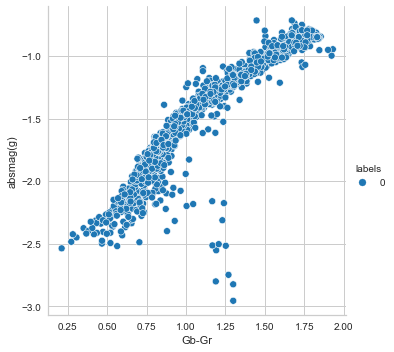

In [673]:
model_aux = model2.drop(model2.loc[model2['labels']==0].index)
model2 = model2.loc[model2['labels']==0]


sns.relplot(
    data=model2,
    x='Gb-Gr', y="absmag(g)",
    hue='labels',palette='tab10'
)

C:\Users\Diego\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([[<AxesSubplot:xlabel='k'>, <AxesSubplot:xlabel='k'>],
       [<AxesSubplot:xlabel='k'>, <AxesSubplot:xlabel='k'>]], dtype=object)

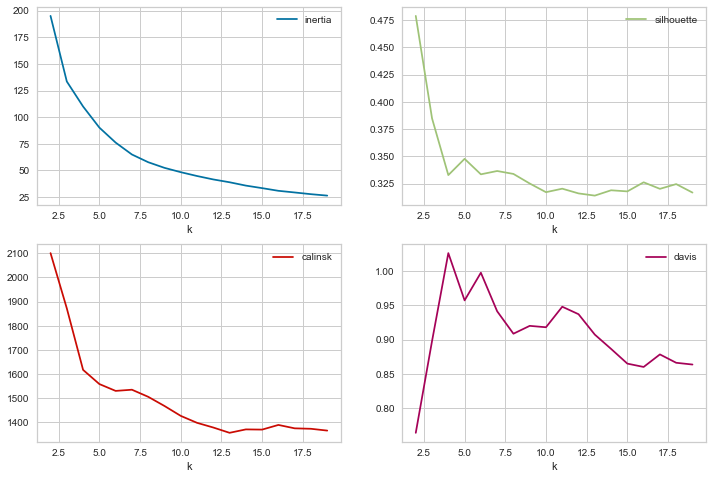

In [564]:
inertias = []
sils = []
chs = []
dbs = []
sizes =range(2,20)
for k in sizes:
    k2 = KMeans(random_state = 42, n_clusters = k)
    k2.fit(df_model2)
    inertias.append(k2.inertia_)
    sils.append(metrics.silhouette_score(df_model2, k2.labels_))
    chs.append(metrics.calinski_harabasz_score(df_model2, k2.labels_))
    dbs.append(metrics.davies_bouldin_score(df_model2, k2.labels_))
    
fig, ax = plt.subplots(figsize=(12, 8))

pd.DataFrame({'inertia': inertias, 'silhouette': sils, 'calinsk': chs, 'davis': dbs, 'k': sizes}).set_index('k').plot(ax=ax,subplots=True,layout=(2,2))

In [674]:
treino2, teste2 = train_test_split(model2, test_size=0.2, random_state=42)
print(len(treino2), 'train + ', len(teste2), 'test')

1178 train +  295 test


In [643]:
kmeans6 = KMeans(n_clusters=6,n_init=10,random_state=42 ).fit(treino2)
k6 = kmeans6.predict(teste2)
kmeans7 = KMeans(n_clusters=7,n_init=10,random_state=42 ).fit(treino2)
k7 = kmeans7.predict(teste2)
kmeans8 = KMeans(n_clusters=8,n_init=10,random_state=42 ).fit(treino2)
k8 = kmeans8.predict(teste2)
kmeans9 = KMeans(n_clusters=9,n_init=10,random_state=42 ).fit(treino2)
k9 = kmeans9.predict(teste2)
kmeans10 = KMeans(n_clusters=10,n_init=10,random_state=42 ).fit(treino2)
k10 = kmeans10.predict(teste2)
kmeans5 = KMeans(n_clusters=5,n_init=10,random_state=42 ).fit(treino2)
k5 = kmeans5.predict(teste2)
kmeans4 = KMeans(n_clusters=4,n_init=10,random_state=42 ).fit(treino2)
k4 = kmeans4.predict(teste2)


In [675]:
kmeans3 = KMeans(n_clusters=3,n_init=10,random_state=42 ).fit(treino2)
k3 = kmeans3.predict(teste2)

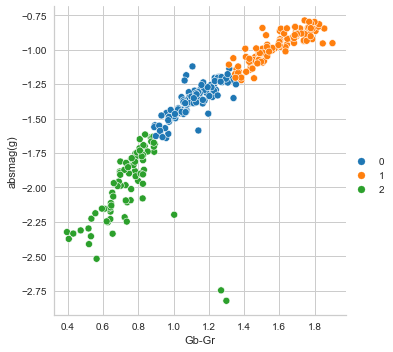

In [676]:

sns.relplot(
    data=teste2,
    x='Gb-Gr', y="absmag(g)",
    hue=k3,palette='tab10'
)

C:\Users\Diego\AppData\Local\Temp/ipykernel_16480/2661157091.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino2['labels'] = kmeans4.labels_
C:\Users\Diego\AppData\Local\Temp/ipykernel_16480/2661157091.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste2['labels'] = k4


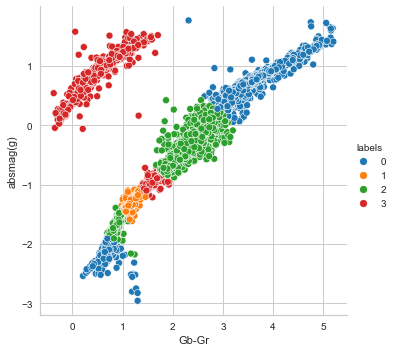

In [642]:
treino2['labels'] = kmeans4.labels_
teste2['labels'] = k4



data = pd.concat([treino2,teste2])
full_data = pd.concat([data,model_aux])

sns.relplot(
    data=full_data,
    x='Gb-Gr', y="absmag(g)",
    hue='labels',palette='tab10'
)

### Teste com todos os dados.

# Modelos.

In [31]:
train_data = train_set.to_numpy()
test_data = test_set.to_numpy()

In [215]:

gm6 = GaussianMixture(n_components=6, random_state=42).fit(train_data)
gm5 = GaussianMixture(n_components=5, random_state=42).fit(train_data)

In [216]:
kmeans6 = KMeans(init="random",n_clusters=6,n_init=10,random_state=42 ).fit(train_data)
kmeans5 = KMeans(init="random",n_clusters=6,n_init=10,random_state=42 ).fit(train_data)

array([3, 2, 0, ..., 3, 3, 5], dtype=int64)

In [229]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics


af = AffinityPropagation(random_state=42).fit(train_data)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print("Estimated number of clusters: %d" % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(train_data, labels, metric="sqeuclidean")
)

Estimated number of clusters: 128


NameError: name 'labels_true' is not defined

In [217]:
ts = test_data.copy()

In [218]:
t_s = pd.DataFrame(ts, columns=test_set.columns)
t_s['class'] = gm.predict(test_data)

In [113]:
t_s['g'] = g['g']
t_s

NameError: name 'g' is not defined

In [122]:
plt.figure(figsize=(20,10))
sns.relplot(
    data=t_s,
    x="freq_eff", y="absmag(g)",
    hue="class", palette='viridis'
)
sns.set(rc={'figure.figsize':(20,16)})

NameError: name 't_s' is not defined

<Figure size 1440x720 with 0 Axes>

In [44]:
from sklearn.cluster import KMeans

kmeans = KMeans(
            init="random",
            n_clusters=5,
            n_init=10,
            random_state=10 )

In [45]:
kmeans.fit(train_data)

NameError: name 'train_data' is not defined

In [222]:
kmeans.predict(test_data)

array([5, 0, 2, ..., 4, 5, 3])

In [223]:
ts = test_data.copy()

In [224]:
t_s = pd.DataFrame(ts, columns=test_set.columns)
t_s['class'] = kmeans.predict(test_data)

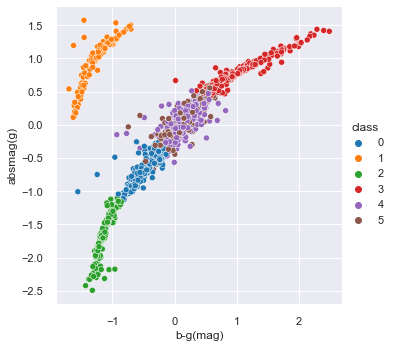

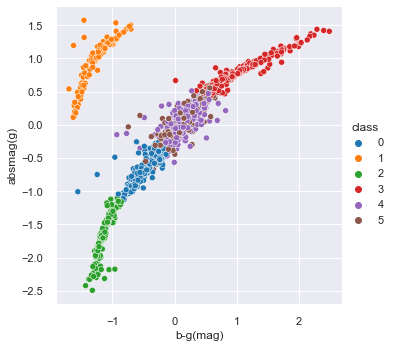

In [226]:
sns.relplot(
    data=t_s,
    x="b-g(mag)", y="absmag(g)",
    hue="class",palette='tab10'
)
sns.relplot(
    data=t_s,
    x="b-g(mag)", y="absmag(g)",
    hue="class",palette='tab10'
)

In [270]:
ptt = pd.read_csv('gaia_model-result.csv')
#y['ra']=y['_RAJ2000']
#y['ra'].round(4)
#pt['ra'] = s['ra'].astype(str)
ptt.dropna(axis=0, how='any', inplace=True)
ptt.info()
ptt

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443528 entries, 0 to 1791604
Data columns (total 13 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   ra                    1443528 non-null  float64
 1   barycentric_distance  1443528 non-null  float64
 2   v_i                   1443528 non-null  float64
 3   mean_absolute_v       1443528 non-null  float64
 4   teff                  1443528 non-null  float64
 5   spectral_type         1443528 non-null  object 
 6   logg                  1443528 non-null  float64
 7   feh                   1443528 non-null  float64
 8   mbol                  1443528 non-null  float64
 9   age                   1443528 non-null  float64
 10  mass                  1443528 non-null  float64
 11  radius                1443528 non-null  float64
 12  population            1443528 non-null  int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 154.2+ MB


,ra,barycentric_distance,v_i,mean_absolute_v,teff,spectral_type,logg,feh,mbol,age,mass,radius,population
0,353.725335,144.74161,1.233,7.75,4295.3643,K5V,4.677,0.032990,7.11,8.5,0.640,0.606249,1
1,353.725417,144.73785,0.999,15.07,5093.3090,DAVII,8.030,0.032990,14.83,8.5,0.600,0.012321,1
3,65.791934,78.56313,2.280,11.55,3443.4993,M2V,4.987,-0.498293,9.75,8.5,0.280,0.279674,1
4,8.067447,182.41447,1.165,7.42,4477.1330,K4.5V,4.666,0.125812,6.87,8.5,0.661,0.623234,1
5,8.067437,182.41454,2.083,11.84,3475.3616,M2V,5.093,0.125812,10.34,8.5,0.200,0.209243,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1791599,277.817924,195.51306,1.869,10.00,3767.0380,M1V,4.915,-0.767987,8.75,10.0,0.409,0.370383,2
1791600,161.184867,100.14810,1.010,0.76,4742.4200,G9III,2.614,-0.030998,0.38,1.5,1.882,11.031925,1
1791601,161.184502,100.14981,1.171,7.00,4570.8820,K4V,4.605,-0.030998,6.43,1.5,0.809,0.732236,1
1791603,13.905215,178.62822,1.060,7.20,4655.8610,K4V,4.678,-0.041322,6.73,10.0,0.662,0.614683,2


In [268]:
stt = pd.read_csv('stars_ggdrless.txt', sep= ' ')
#s['id'] = s['source_id']
#s['id'] = s['id'].astype(str)
#s['ra'].round(4)
#s['ra'] = s['ra'].astype(str)
stt

,id,ra,dec,parallax,pm,freq_eff,g_band(mag),b_band(mag),r_band(mag),b-r(mag),b-g(mag),g-r(mag),l,b
0,3781327832039804160,157.523249,-2.591879,7.000003,36.325535,1.257106,16.742850,18.309256,15.539074,2.770182,1.566406,1.203775,248.413311,44.802440
1,160105836651833600,73.620428,31.499510,7.000007,49.957104,1.266479,16.211855,17.729303,15.016982,2.712321,1.517448,1.194873,171.575869,-7.609054
2,2882530608807142528,90.497362,-40.171223,7.000009,29.450960,1.369841,13.711228,14.595704,12.785631,1.810073,0.884476,0.925597,246.723454,-26.087072
3,3829652501951933312,151.068280,-1.861213,7.000010,28.138224,1.228052,16.266370,17.440048,14.563461,2.876587,1.173677,1.702910,241.898430,40.420782
4,5675763517472966016,138.797126,-22.494523,7.000010,38.404530,1.307066,15.134747,16.351723,14.042218,2.309505,1.216976,1.092528,251.089407,17.947132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633769,4075141768785646848,282.458789,-23.837097,336.026602,668.139900,1.256002,9.126414,10.732183,7.898147,2.834036,1.605769,1.228267,11.307625,-10.287476
633770,762815470562110464,165.830960,35.948653,392.752945,4811.680000,1.297933,6.551172,7.691122,5.475513,2.215609,1.139950,1.075659,185.169510,65.433988
633771,3864972938605115520,164.103190,7.002727,415.179416,4715.329600,1.088607,11.038391,13.770287,9.585450,4.184836,2.731895,1.452941,244.051151,56.098853
633772,4472832130942575872,269.448503,4.739420,546.975940,10393.349000,1.257181,8.193974,9.791788,6.958091,2.833697,1.597814,1.235883,31.049418,14.086604


In [269]:
pl = pd.merge(ptt, stt, how = 'inner', on = 'ra')
pl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ra                    0 non-null      float64
 1   barycentric_distance  0 non-null      float64
 2   v_i                   0 non-null      float64
 3   mean_absolute_v       0 non-null      float64
 4   teff                  0 non-null      float64
 5   spectral_type         0 non-null      object 
 6   logg                  0 non-null      float64
 7   feh                   0 non-null      float64
 8   mbol                  0 non-null      float64
 9   age                   0 non-null      float64
 10  mass                  0 non-null      float64
 11  radius                0 non-null      float64
 12  population            0 non-null      int64  
 13  id                    0 non-null      int64  
 14  dec                   0 non-null      float64
 15  parallax              0 non-null      fl

In [155]:
stars_full_dataset

,ra,barycentric_distance,v_i,mean_absolute_v,teff,spectral_type,logg,feh,mbol,age,...,pm,freq_eff,g_band(mag),b_band(mag),r_band(mag),b-r(mag),b-g(mag),g-r(mag),l,b
0,157.5232489332873,144.74161,1.233000,7.750000,4295.3643,K5V,4.677,0.032990,7.110000,8.500,...,36.325535,1.257106,16.742850,18.309256,15.539074,2.770182,1.566406,1.203775,248.413311,44.802440
1,73.62042787972024,144.73785,0.999000,15.070000,5093.3090,DAVII,8.030,0.032990,14.830000,8.500,...,49.957104,1.266479,16.211855,17.729303,15.016982,2.712321,1.517448,1.194873,171.575869,-7.609054
2,90.49736234948313,144.73979,1.232752,7.748719,NaN,NaN,NaN,0.032990,7.109114,8.500,...,29.450960,1.369841,13.711228,14.595704,12.785631,1.810073,0.884476,0.925597,246.723454,-26.087072
3,151.06828047278373,78.56313,2.280000,11.550000,3443.4993,M2V,4.987,-0.498293,9.750000,8.500,...,28.138224,1.228052,16.266370,17.440048,14.563461,2.876587,1.173677,1.702910,241.898430,40.420782
4,138.79712611420302,182.41447,1.165000,7.420000,4477.1330,K4.5V,4.666,0.125812,6.870000,8.500,...,38.404530,1.307066,15.134747,16.351723,14.042218,2.309505,1.216976,1.092528,251.089407,17.947132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633769,282.4587890175222,175.82219,2.155000,10.850000,3499.4517,M2V,4.907,-0.015893,9.200000,0.575,...,668.139900,1.256002,9.126414,10.732183,7.898147,2.834036,1.605769,1.228267,11.307625,-10.287476
633770,165.83095967577933,157.45526,6.265000,23.600000,1629.2960,L5V,5.360,0.039581,12.880000,2.500,...,4811.680000,1.297933,6.551172,7.691122,5.475513,2.215609,1.139950,1.075659,185.169510,65.433988
633771,164.10319030755974,157.45245,4.117000,17.500000,2636.3313,M6.5V,5.300,0.039581,12.950000,2.500,...,4715.329600,1.088607,11.038391,13.770287,9.585450,4.184836,2.731895,1.452941,244.051151,56.098853
633772,269.4485025254384,157.45050,6.336000,24.000000,1599.5580,L5V,5.360,0.039581,12.890000,2.500,...,10393.349000,1.257181,8.193974,9.791788,6.958091,2.833697,1.597814,1.235883,31.049418,14.086604


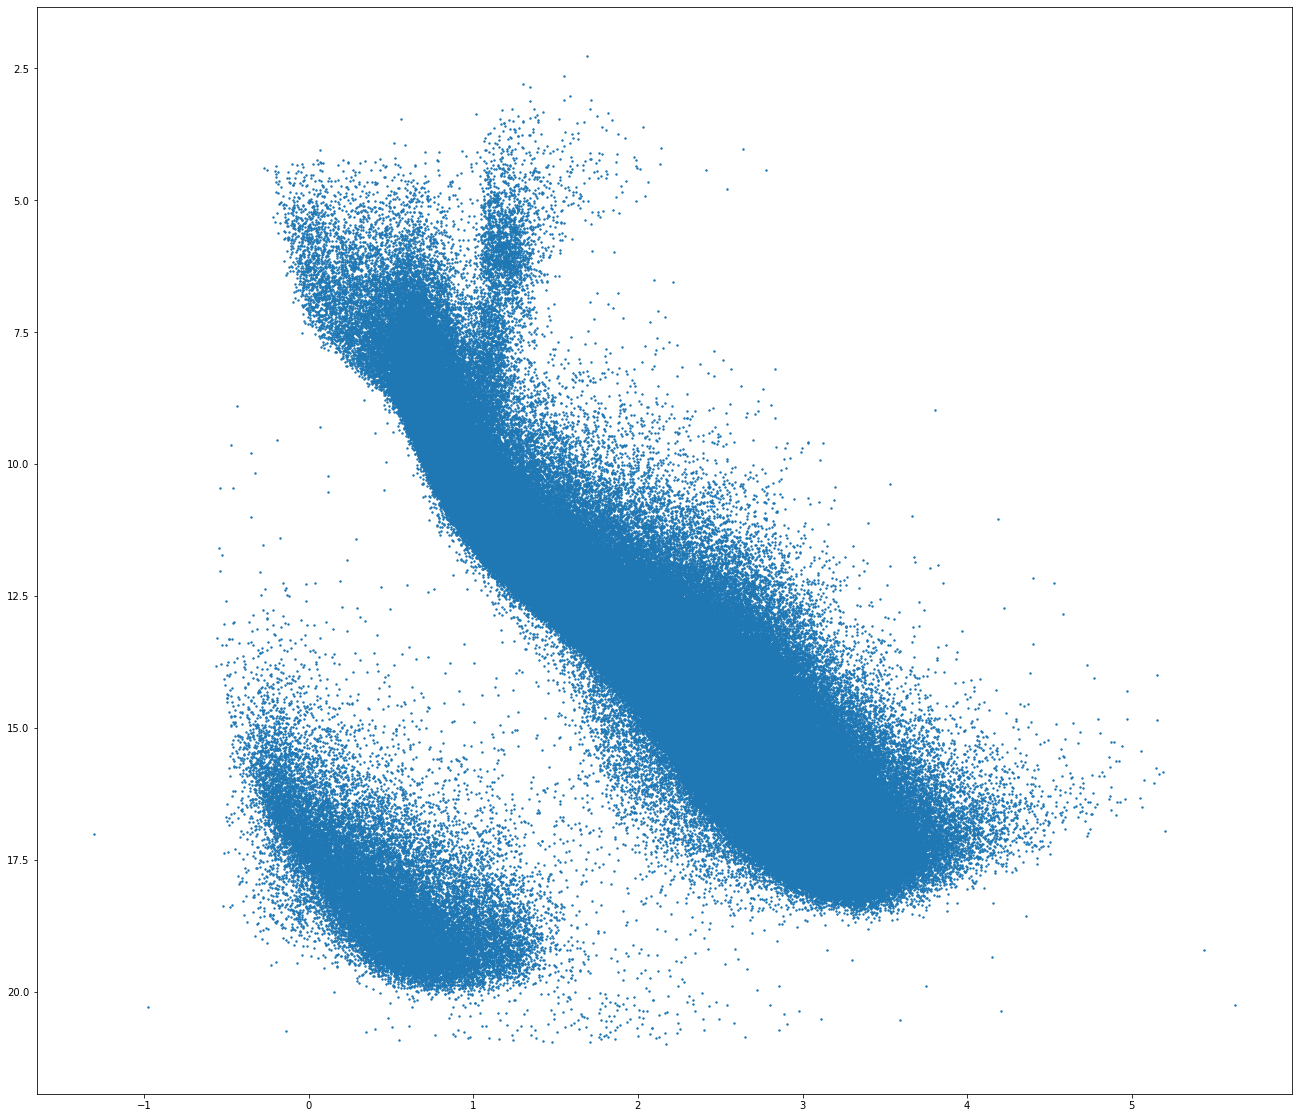

In [165]:
f, ax = plt.subplots(figsize=(22.5,20))
plt.scatter(x=stars_full_dataset['b-r(mag)'], y=stars_full_dataset['g_band(mag)'], s=2)
ax.invert_yaxis()

In [ ]:
comparation = pd.DataFrame()

comparation['all'] = stars_properties['freq'].value_counts()/len(stars_properties)
comparation['random'] = test_set['freq'].value_counts()/len(test_set)

comparation['random_error(%)'] = ((comparation['all']-comparation['random'])*100)/comparation['all']
comparation.info()

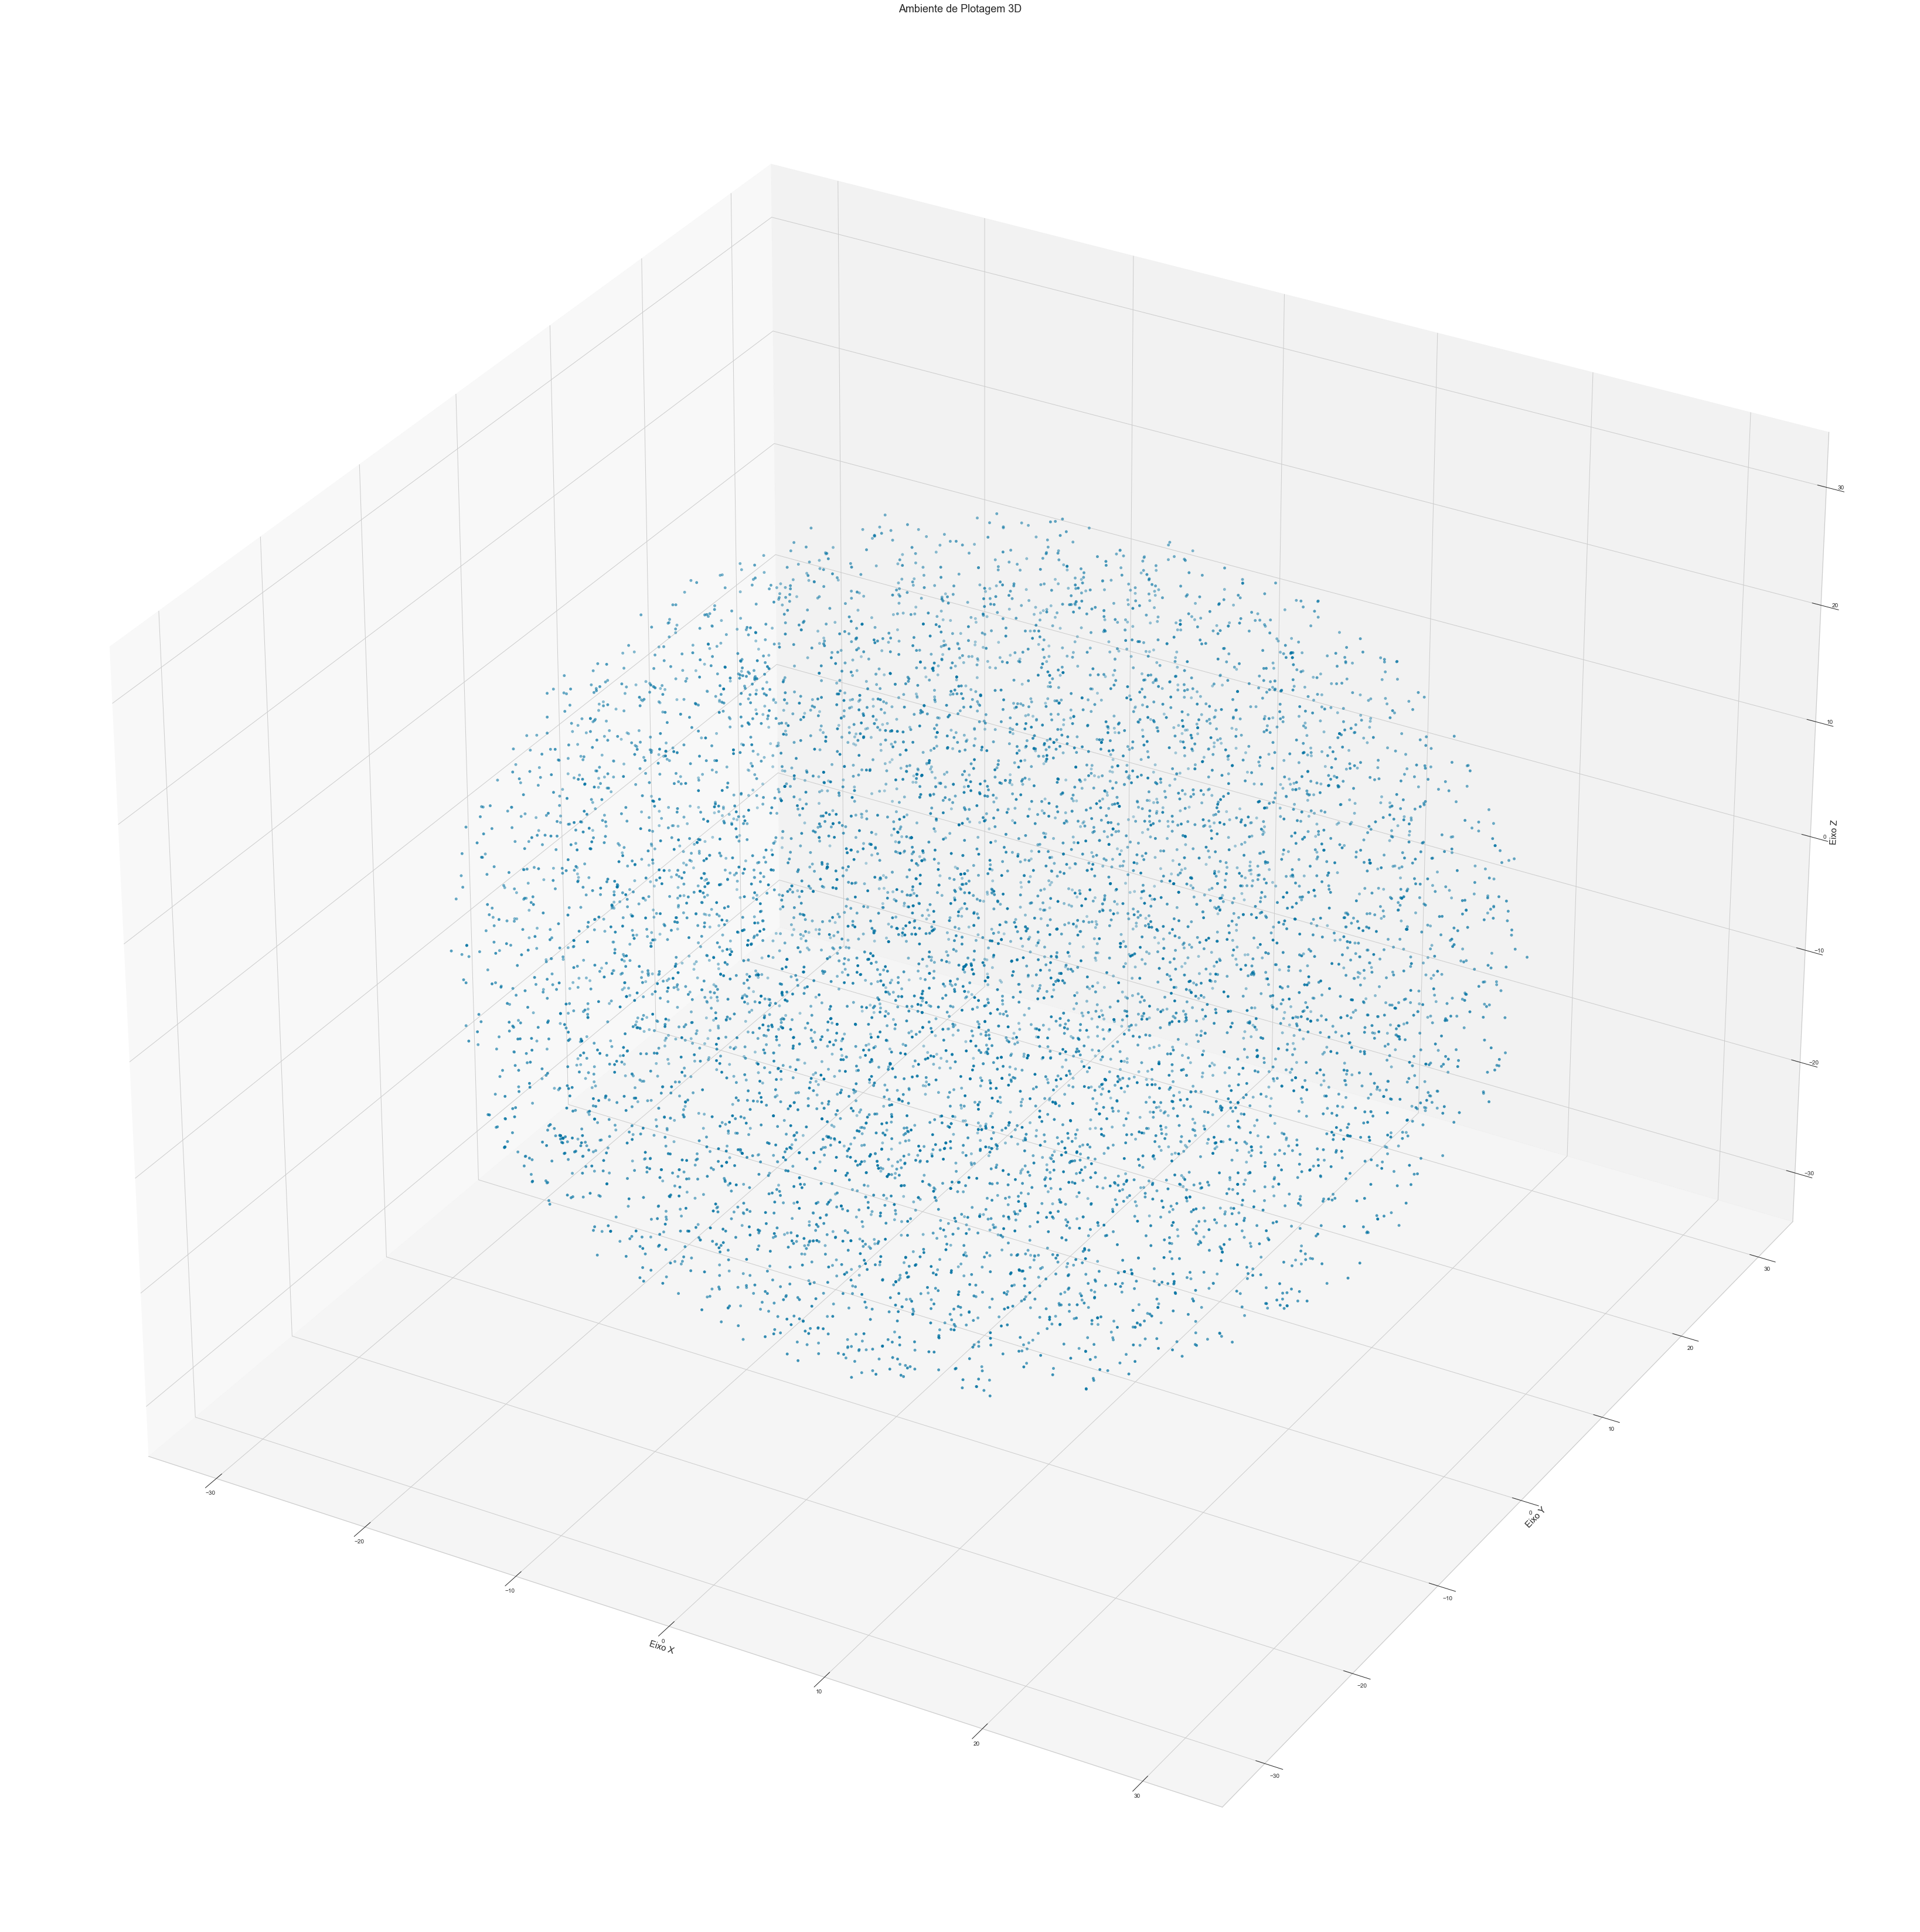

In [74]:

fig  = plt.figure(figsize=(80, 60))
ax = plt.axes(projection="3d")
ax.set_title('Ambiente de Plotagem 3D', fontsize=18)
ax.set_xlabel('Eixo X', fontsize=15)
ax.set_ylabel('Eixo Y', fontsize=15)
ax.set_zlabel('Eixo Z', fontsize=15)
ax.scatter(stars_data['x'], stars_data['y'], stars_data['z'], 'purple')

plt.show()

KeyError: "None of [Int64Index([5, 1, 3, 2, 2, 2, 2, 1, 1, 1,\n            ...\n            0, 4, 3, 5, 0, 1, 3, 0, 2, 1],\n           dtype='int64', length=1524)] are in the [columns]"

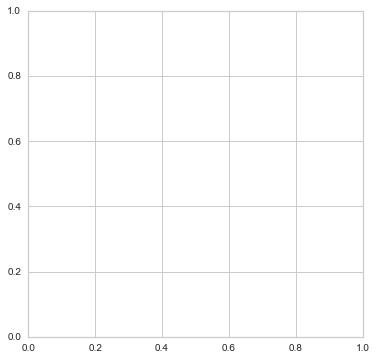

In [355]:
fig, ax = plt.subplots(figsize=(6,6))
df = stars_data.copy()
radviz(test_set,k6,ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
df = df_model.copy()
df['t']=0
radviz(df,'t',ax=ax)

In [430]:
from astroquery.vizier import Vizier

In [431]:
t.load_tables(only_names=True)
for table in tables:
    print(table.name)

NameError: name 'vizier' is not defined